 * Hugging Faceの公式ページ -> https://huggingface.co/

* 今回用いるECAPA-TDNNのページ ->https://huggingface.co/speechbrain/spkrec-ecapa-voxceleb

## 環境構築


In [1]:
from google.colab import drive
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content

/content


In [ ]:
#pythonのバージョン確認
!python -V

Python 3.10.12


In [ ]:
#cudaのバージョン確認
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [3]:
#必要なライブラリのインストール
!pip install speechbrain
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install matplotlib japanize-matplotlib typing scipy scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.6/630.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 25.8 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 20.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=6ecb7651a4ac09fdf556c19c0c426b8e1530329459f900d4113840a3bf8faed4
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26304 sha256=

In [ ]:
#事前学習モデルのロード
from speechbrain.pretrained import SpeakerRecognition
verification = SpeakerRecognition.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    savedir="pretrained_models/spkrec-ecapa-voxceleb",
    run_opts={"device":"cuda"},
    )

hyperparams.yaml:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

In [ ]:
from typing import List
from scipy.interpolate import interp1d
from scipy.optimize import brentq
from sklearn.metrics import roc_curve ,auc
import matplotlib.pyplot as plt

from tqdm import tqdm
import re

## 照合

In [ ]:
#EERを求める関数
#FRR=1-TPRであることに留意
def compute_eer(labels: List[int], scores: List[float]):
    fpr, tpr, thresholds = roc_curve(labels, scores, pos_label=1)
    eer = brentq(lambda x: 1.0 - x - interp1d(fpr, tpr)(x), 0.0, 1.0)
    eer_threshold = interp1d(fpr, thresholds)(eer)
    return fpr, tpr, thresholds, eer, eer_threshold

複数のwav_pair_listに対してEERとROCカーブを出力する処理を行いたいため，処理を関数化．

ここまでやるならクラス化したほうがいいと言われた，確かに．


In [ ]:
# ディレクトリ移動
%cd /content/

# /content/drive/ 内からdrive/内にファイルを作成しようとしたらエラーが出るので，目的のディレクトリを保持しておく．
TAR_DIR = "/content/drive/MyDrive/CS_seminar/7th"
LIST_DIR = "/content/drive/MyDrive/CS_seminar/data/list"

/content


In [ ]:
def parse_listfile(wav_list_path):
  labels = []
  wav1 = []
  wav2 = []

  with open(wav_list_path) as f:
    for line in f:
      line = line.rstrip().split(' ')
      labels.append(int(line[0]))
      wav1.append(line[1])
      wav2.append(line[2])
  return labels, wav1, wav2

In [ ]:
def gen_audio_cache_filename(wav_path: str) -> str:
  result = re.match(r".*/(.+?)/(.+)/(.+?)\.wav", wav_path)
  spk, cond, wavname = result.groups()
  return f"{spk}-{cond}-{wavname}"

#### `SpeakerRecognition.verify_files(self, path_x, path_y, **kwargs)`について
- 中で呼び出されている`self.load_audio(path_x/y, **kwargs)`で，音声を`./audio_cache`にキャッシュしている．
- この時，`**kwargs==None`だと，参照する音声ファイルの`{filename}.wav`を`./audio_cache`にキャッシュする．
- また，同じ`**kwargs`を二つの音声に対する`load_audio()`に渡している．
- これでは同一のファイル名の音声が同一のファイルとして参照されてしまい，違う話者and同一のwav名の場合に正しくスコアが計算できない．
- したがって，キャッシュする音声のファイル名にディレクトリの情報を保持できるように処理を変更する．

---

`SpeakerRecognition.verify_files(*)`は`/usr/local/lib/python3.10/dist-packages/speechbrain/pretrained/interfaces.py`@1198に実装されています．

`Pretrained.load_audio(*)`は@274で実装されています．`**kwargs`に与えられるキーワードは`/usr/local/lib/python3.10/dist-packages/speechbrain/pretrained/fetching.py`に説明されています．




In [ ]:
def calc_scores(labels: List[int], wav1: List[str], wav2: List[str]) -> List[float]:
  scores = []
  for i in tqdm(range(len(labels))):
###
    waveform_x = verification.load_audio(
        wav1[i],
        save_filename=gen_audio_cache_filename(wav1[i])
        )
    waveform_y = verification.load_audio(
        wav2[i],
        save_filename=gen_audio_cache_filename(wav2[i])
        )
    # Fake batches:
    batch_x = waveform_x.unsqueeze(0)
    batch_y = waveform_y.unsqueeze(0)
    # Verify:
    score, decision = verification.verify_batch(batch_x, batch_y)
    # Squeeze:
    score, prediction = score[0], decision[0]
###
    scores.append(score.item())
  return scores


In [ ]:
def eer_roc_pipeline(wav_list_path: str):
  # 音声対が列挙されたファイルを，ラベル，音声1，音声2のリストに分割
  labels, wav1, wav2 = parse_listfile(wav_list_path)
  # 音声ファイル対について，スコアを計測
  scores = calc_scores(labels, wav1, wav2)
  # 評価値を計算
  fpr, tpr, th, eer, eer_th = compute_eer(labels, scores)

  #FAR,FRR,EERの図のプロット
  title = re.match(r".*/(.+).txt", wav_list_path).group(1)
  plt.figure()
  plt.plot(th, fpr, marker='o', markersize=1, label="FAR")
  plt.plot(th, 1-tpr, marker='o', markersize=1, label="FRR")
  plt.plot(eer_th,eer,marker='*', markersize=10, color="red")
  plt.xlabel('Threshold')
  plt.ylabel('Error Rate')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)
  plt.title(f"Error Rate Curve: {title}, EER: {eer:.5f}")
  plt.grid()
  plt.savefig(f"{TAR_DIR}/fig/{title}/eer", bbox_inches='tight', dpi=600)

  # scoreの箱ひげ図をプロット
  true_pair_scores: List[float] = []
  false_pair_scores: List[float] = []
  for idx, score in enumerate(scores):
    if labels[idx] == 1:
      true_pair_scores.append(score)
    else:
      false_pair_scores.append(score)
  # plot
  plt.figure()
  plt.boxplot(
      [true_pair_scores, false_pair_scores],
      labels = ["true-pairs", "false-pairs"],
  )
  plt.title(f"Boxplot of Scores for Each Labels")
  plt.hlines(eer_th, 0.8, 2.2)
  plt.ylim(-0.3, 0.8)
  plt.grid()
  plt.savefig(f"{TAR_DIR}/fig/{title}/box", bbox_inches='tight', dpi=600)

  # 詳細を出力
  print(f"wav_list:{wav_list_path}")
  print(f"pairs:{len(labels)}")
  # print("fpr:", fpr)
  # print("tpr:", tpr)
  # print("roc_th:", th)
  print("eer:", eer)
  print("eer_th:", eer_th)


  # pcのtrue_pairのscoreが全体的に低い気がするので，trueでscore < eer_thの対を出力してみる．
  print(f"FalseNegatives(eer_th:{eer_th})")
  for idx, score in enumerate(scores):
    if score < eer_th and labels[idx] == 1:
      print(f"score:{score} {wav1[idx]}, {wav2[idx]}")

  # キャッシュを削除
  !rm -r /content/audio_cache/


100%|██████████| 465/465 [00:19<00:00, 23.28it/s]


wav_list:/content/drive/MyDrive/CS_seminar/data/list/pc.txt
pairs:465
eer: 0.11111111111063529
eer_th: 0.14905281489126118
FalseNegatives(eer_th:0.14905281489126118)
score:0.12709996104240417 /content/drive/MyDrive/CS_seminar/data/wav/ymgt_A/pc/ymgt-A_pc_01.wav, /content/drive/MyDrive/CS_seminar/data/wav/ymgt_A/pc/ymgt-A_pc_02.wav
score:0.028317326679825783 /content/drive/MyDrive/CS_seminar/data/wav/ymgt_A/pc/ymgt-A_pc_02.wav, /content/drive/MyDrive/CS_seminar/data/wav/ymgt_A/pc/ymgt-A_pc_06.wav
score:0.12670762836933136 /content/drive/MyDrive/CS_seminar/data/wav/ymgt_C/pc/ymgt-C_pc_01.wav, /content/drive/MyDrive/CS_seminar/data/wav/ymgt_C/pc/ymgt-C_pc_02.wav
score:0.07980848848819733 /content/drive/MyDrive/CS_seminar/data/wav/ymgt_C/pc/ymgt-C_pc_01.wav, /content/drive/MyDrive/CS_seminar/data/wav/ymgt_C/pc/ymgt-C_pc_03.wav
score:0.0730365440249443 /content/drive/MyDrive/CS_seminar/data/wav/ymgt_D/pc/ymgt-D_pc_01.wav, /content/drive/MyDrive/CS_seminar/data/wav/ymgt_D/pc/ymgt-D_pc_05.wav

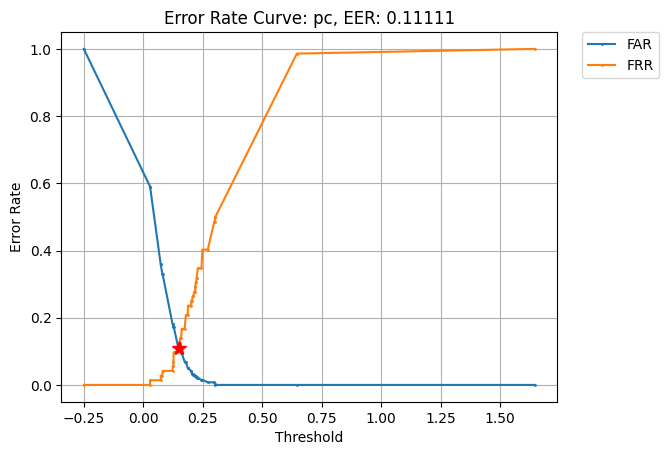

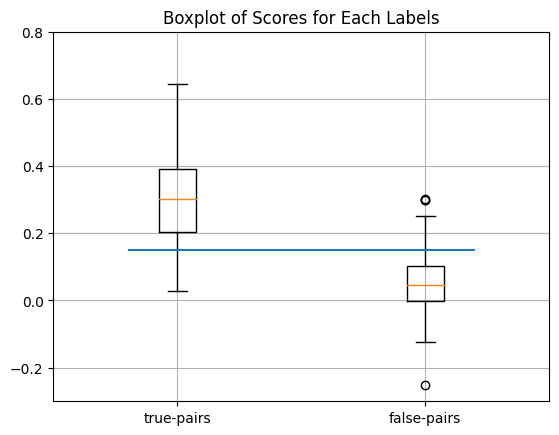

In [ ]:
# `pc`
eer_roc_pipeline(f"{LIST_DIR}/pc.txt")

100%|██████████| 465/465 [00:20<00:00, 23.22it/s]


wav_list:/content/drive/MyDrive/CS_seminar/data/list/sp.txt
pairs:465
eer: 0.06615776081549547
eer_th: 0.1831274926658716
FalseNegatives(eer_th:0.1831274926658716)
score:0.15528130531311035 /content/drive/MyDrive/CS_seminar/data/wav/ymgt_D/sp/ymgt-D_sp_01.wav, /content/drive/MyDrive/CS_seminar/data/wav/ymgt_D/sp/ymgt-D_sp_05.wav
score:0.16189070045948029 /content/drive/MyDrive/CS_seminar/data/wav/ymgt_D/sp/ymgt-D_sp_02.wav, /content/drive/MyDrive/CS_seminar/data/wav/ymgt_D/sp/ymgt-D_sp_03.wav
score:0.18226751685142517 /content/drive/MyDrive/CS_seminar/data/wav/ymgt_D/sp/ymgt-D_sp_04.wav, /content/drive/MyDrive/CS_seminar/data/wav/ymgt_D/sp/ymgt-D_sp_06.wav
score:0.12314678728580475 /content/drive/MyDrive/CS_seminar/data/wav/ymgt_D/sp/ymgt-D_sp_05.wav, /content/drive/MyDrive/CS_seminar/data/wav/ymgt_D/sp/ymgt-D_sp_06.wav


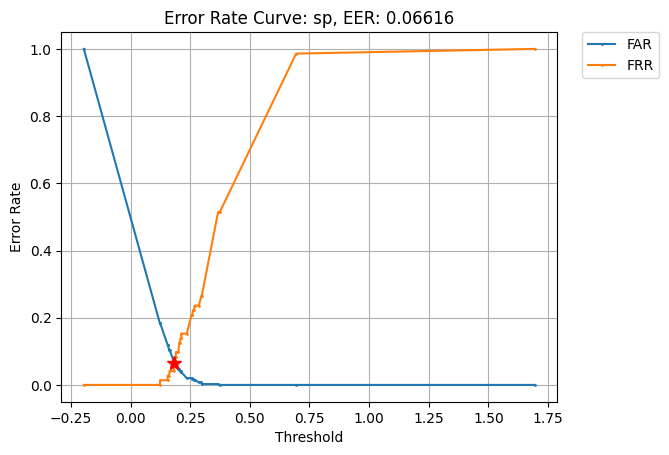

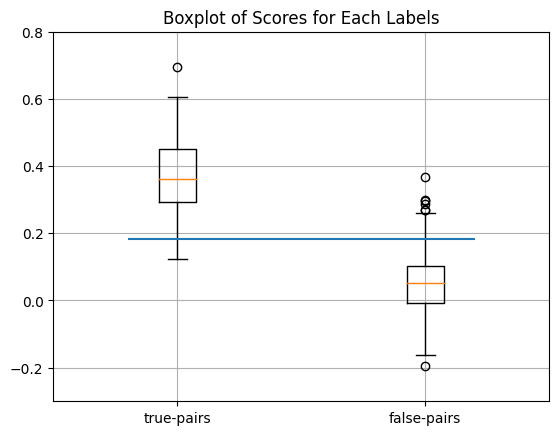

In [ ]:
# `sp`
eer_roc_pipeline(f"{LIST_DIR}/sp.txt")

100%|██████████| 171/171 [00:07<00:00, 23.21it/s]


wav_list:/content/drive/MyDrive/CS_seminar/data/list/pc_noAC.txt
pairs:171
eer: 0.10852713178260279
eer_th: 0.15727859735492317
FalseNegatives(eer_th:0.15727859735492317)
score:0.0730365440249443 /content/drive/MyDrive/CS_seminar/data/wav/ymgt_D/pc/ymgt-D_pc_01.wav, /content/drive/MyDrive/CS_seminar/data/wav/ymgt_D/pc/ymgt-D_pc_05.wav
score:0.1228519007563591 /content/drive/MyDrive/CS_seminar/data/wav/ymgt_D/pc/ymgt-D_pc_01.wav, /content/drive/MyDrive/CS_seminar/data/wav/ymgt_D/pc/ymgt-D_pc_06.wav
score:0.1528782993555069 /content/drive/MyDrive/CS_seminar/data/wav/ymgt_D/pc/ymgt-D_pc_02.wav, /content/drive/MyDrive/CS_seminar/data/wav/ymgt_D/pc/ymgt-D_pc_03.wav
score:0.12583622336387634 /content/drive/MyDrive/CS_seminar/data/wav/ymgt_D/pc/ymgt-D_pc_02.wav, /content/drive/MyDrive/CS_seminar/data/wav/ymgt_D/pc/ymgt-D_pc_05.wav
score:0.14505170285701752 /content/drive/MyDrive/CS_seminar/data/wav/ymgt_D/pc/ymgt-D_pc_04.wav, /content/drive/MyDrive/CS_seminar/data/wav/ymgt_D/pc/ymgt-D_pc_06.w

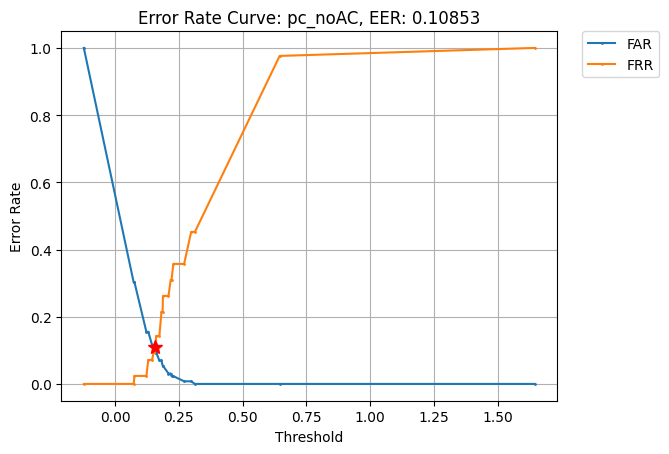

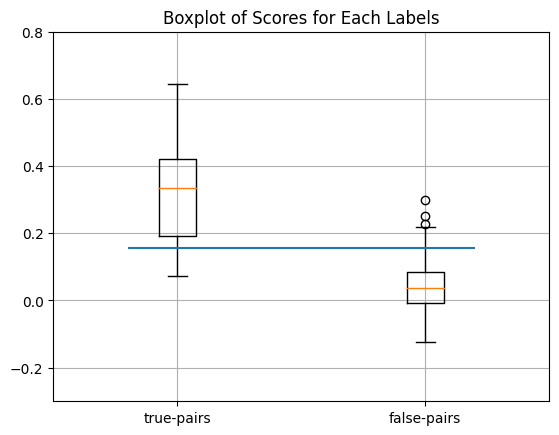

In [ ]:
# 追検証pc

eer_roc_pipeline(f"{LIST_DIR}/pc_noAC.txt")

100%|██████████| 171/171 [00:07<00:00, 22.95it/s]


wav_list:/content/drive/MyDrive/CS_seminar/data/list/sp_noAC.txt
pairs:171
eer: 0.06976744186012467
eer_th: 0.16983109712618913
FalseNegatives(eer_th:0.16983109712618913)
score:0.15528130531311035 /content/drive/MyDrive/CS_seminar/data/wav/ymgt_D/sp/ymgt-D_sp_01.wav, /content/drive/MyDrive/CS_seminar/data/wav/ymgt_D/sp/ymgt-D_sp_05.wav
score:0.16189070045948029 /content/drive/MyDrive/CS_seminar/data/wav/ymgt_D/sp/ymgt-D_sp_02.wav, /content/drive/MyDrive/CS_seminar/data/wav/ymgt_D/sp/ymgt-D_sp_03.wav
score:0.12314678728580475 /content/drive/MyDrive/CS_seminar/data/wav/ymgt_D/sp/ymgt-D_sp_05.wav, /content/drive/MyDrive/CS_seminar/data/wav/ymgt_D/sp/ymgt-D_sp_06.wav


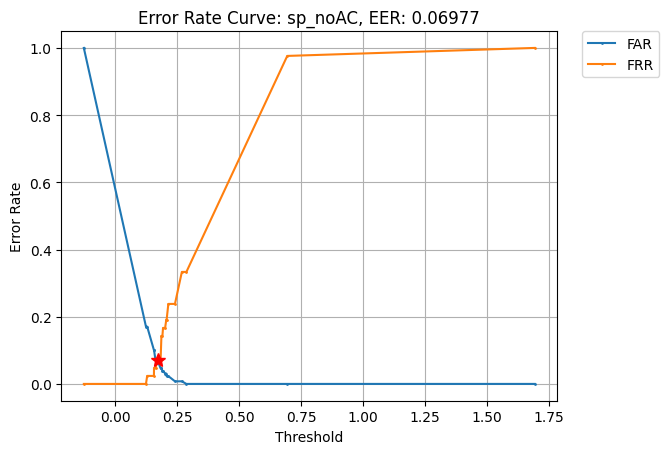

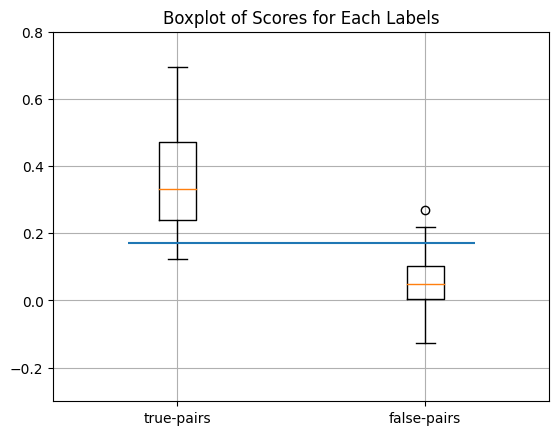

In [ ]:
# 追検証sp

eer_roc_pipeline(f"{LIST_DIR}/sp_noAC.txt")

---
類似度の分布も見てみる
条件ごとのscore(cos_simil)の分布

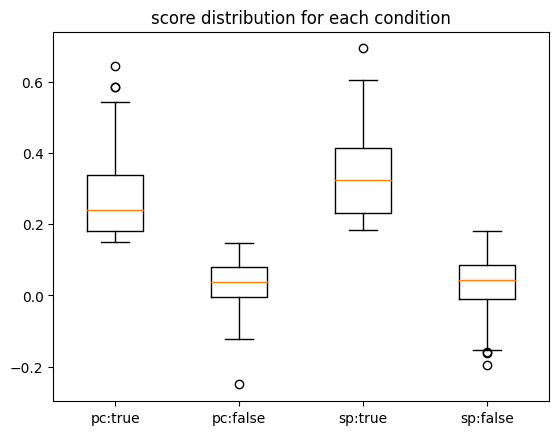

In [ ]:
# SCORE_LOGのunzip
plot_labels = []
plot_data = []
for cond, tfs in SCORE_LOG.items():
  for tf, data in tfs.items():
    plot_labels.append(f"{cond}:{tf}")
    plot_data.append(data)

# plot
plt.figure()
plt.boxplot(plot_data, labels=plot_labels)
plt.title("score distribution for each condition")
# plot eer_th line
plt.hline
plt.savefig(f"{TAR_DIR}/fig/score_box.png", bbox_inches='tight', dpi=600)